In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.utils.vis_utils import plot_model
PATH = Path('/content/gdrive/My Drive/REU Materials/Data')

In [ ]:
X_train = pd.read_csv(PATH/'train.csv')

In [ ]:
X_train.head()

,Unnamed: 0,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
0,631052,0.6,0.8,0.4,0.8,0.8,1.0,0.2,0.6,0.4,0.8,0.8,0.6,0.6,0.6,1.0,0.2,0.6,0.6,0.4,0.6,0.8,0.6,0.4,0.8,0.8,1.0,0.4,0.4,1.0,0.6,0.6,0.2,0.6,0.4,0.6,0.8,1.0,0.4,0.6,0.6,0.8,0.6,0.6,0.6,0.8,0.4,0.8,0.2,0.6,0.6
1,770974,0.2,0.2,1.0,1.0,0.6,1.0,0.2,0.2,0.2,0.6,0.2,0.6,0.6,0.2,0.2,0.2,0.6,0.6,0.2,0.2,1.0,0.6,0.2,0.6,0.2,1.0,0.2,0.6,1.0,1.0,1.0,1.0,1.0,0.2,1.0,0.2,1.0,0.6,1.0,0.2,0.6,0.2,0.6,0.2,0.6,0.2,1.0,0.6,0.6,0.6
2,811924,0.2,0.6,0.8,0.6,1.0,0.2,0.2,0.8,0.8,0.6,0.4,1.0,0.8,0.4,0.2,0.4,0.4,0.4,0.4,0.2,0.4,0.8,0.8,0.4,0.2,1.0,0.4,0.6,0.2,0.4,0.8,0.2,0.8,0.2,0.6,0.2,0.8,0.2,0.8,0.8,1.0,0.4,0.4,0.2,0.8,0.6,1.0,0.8,1.0,0.4
3,964914,0.4,0.6,0.8,0.6,0.8,0.4,0.4,0.4,0.6,0.4,0.8,0.8,0.4,0.8,0.4,0.4,0.4,0.2,0.2,0.4,0.4,0.8,0.2,0.8,0.2,0.8,0.2,0.8,0.8,0.8,0.4,0.6,0.6,0.4,0.6,0.4,0.4,0.2,0.2,0.6,0.6,0.8,0.8,0.2,0.6,0.2,0.8,0.6,0.8,0.8
4,691563,0.4,1.0,0.6,1.0,0.4,0.8,0.4,1.0,0.6,1.0,1.0,0.8,0.8,0.8,0.6,0.6,0.8,0.4,0.8,0.4,0.4,0.8,0.2,1.0,1.0,1.0,0.4,0.8,0.8,0.6,0.6,0.6,0.8,0.8,0.4,0.6,0.8,0.6,0.8,0.6,1.0,0.4,1.0,0.4,0.6,0.2,0.8,0.8,1.0,1.0


In [ ]:
X_train.shape

(709490, 51)

In [ ]:
X_train.columns

Index(['Unnamed: 0', 'EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7',
       'EXT8', 'EXT9', 'EXT10', 'EST1', 'EST2', 'EST3', 'EST4', 'EST5', 'EST6',
       'EST7', 'EST8', 'EST9', 'EST10', 'AGR1', 'AGR2', 'AGR3', 'AGR4', 'AGR5',
       'AGR6', 'AGR7', 'AGR8', 'AGR9', 'AGR10', 'CSN1', 'CSN2', 'CSN3', 'CSN4',
       'CSN5', 'CSN6', 'CSN7', 'CSN8', 'CSN9', 'CSN10', 'OPN1', 'OPN2', 'OPN3',
       'OPN4', 'OPN5', 'OPN6', 'OPN7', 'OPN8', 'OPN9', 'OPN10'],
      dtype='object')

In [ ]:
X_train.drop('Unnamed: 0', axis = 1, inplace = True)

In [ ]:
X_train = X_train.to_numpy()

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

  #computing the gradient with GradientTape
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
'''  
VAE Code:
          Encoder with n inputs
          n ==> representing the number of questions/ items

          No convolutional layers(used mainly with images), does not make sense since we are looking at a 1 dim vector
          No flatten

          Make a your own class file to represent the model at the start to streamline how the data is used

          Use sequential ==> sequential can only release 1 output
          
          Look @ R folder

          Two parts ==> encoder and decoder both sequential with dense layers input 50 ==> latent 2 ==> output 50

          keep sampling
'''
#latent == num of traits??
traits = 5
questions = 10
n = 50

#Test encoder code for functional structure VAE

encoder_inputs = Input(shape = (n, ))
x = Dense(25, activation="relu")(encoder_inputs)
x = Dense(10, activation = 'relu')(x)


#latent/ bottleneck
z_mean = Dense(traits, name = "z_mean")(x)
z_log_var = Dense(traits, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

#encoder = keras.Model(encoder_inputs, z_mean, name="encoder")
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 25)           1275        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           260         dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 5)            55          dense_1[0][0]                    
____________________________________________________________________________________________

In [ ]:
#test code for the decoder for our VAE model
latent_inputs = Input(shape = (traits, ))
x = Dense(10, activation="relu")(latent_inputs)
x = Dense(25, activation="relu")(x)
decoder_outputs = Dense(n, activation="relu")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_3 (Dense)              (None, 25)                275       
_________________________________________________________________
dense_4 (Dense)              (None, 50)                1300      
Total params: 1,635
Trainable params: 1,635
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Here we put the encoder and the decoder together to form our VAE

final_output = decoder(encoder(encoder_inputs)[2])
#print(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, final_output)

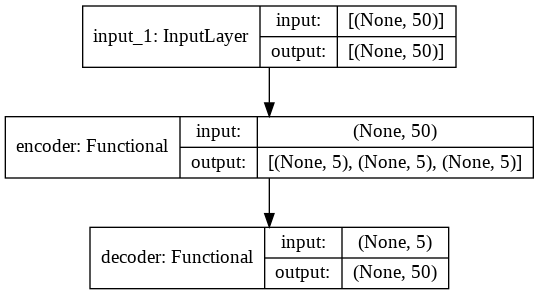

In [ ]:
 plot_model(vae, show_shapes=True, show_layer_names=True)

In [ ]:
from keras.losses import binary_crossentropy
from keras import backend as K

reconstruction_loss = binary_crossentropy(encoder_inputs, final_output)
reconstruction_loss *= 50
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis = -1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [ ]:
vae.add_loss(vae_loss)
vae.compile(loss = 'binary_crossentropy', optimizer = 'Adam')
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 5), (None, 5 1645        input_1[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 50)           1635        encoder[0][2]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 25)           1275        input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
history = vae.fit(X_train, X_train, epochs = 300, batch_size = 128)

Epoch 1/300
5543/5543 [==============================] - 26s 2ms/step - loss: 74.4389
Epoch 2/300
5543/5543 [==============================] - 10s 2ms/step - loss: 56.1175
Epoch 3/300
5543/5543 [==============================] - 10s 2ms/step - loss: 56.0049
Epoch 4/300
5543/5543 [==============================] - 10s 2ms/step - loss: 55.9785
Epoch 5/300
5543/5543 [==============================] - 10s 2ms/step - loss: 55.9035
Epoch 6/300
5543/5543 [==============================] - 11s 2ms/step - loss: 55.8510
Epoch 7/300
5543/5543 [==============================] - 11s 2ms/step - loss: 55.8382
Epoch 8/300
5543/5543 [==============================] - 11s 2ms/step - loss: 55.8400
Epoch 9/300
5543/5543 [==============================] - 10s 2ms/step - loss: 55.8409
Epoch 10/300
5543/5543 [==============================] - 11s 2ms/step - loss: 55.8424
Epoch 11/300
5543/5543 [==============================] - 11s 2ms/step - loss: 55.8299
Epoch 12/300
5543/5543 [============================

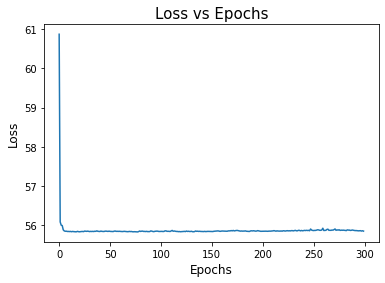

In [ ]:
#history.histoy is a dictionary
plt.plot(history.history['loss'])
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.title("Loss vs Epochs", fontsize = 15)
plt.show()

In [122]:
print(history.history)

{'loss': [60.87179946899414, 56.078670501708984, 55.99498748779297, 55.9870491027832, 55.87728500366211, 55.84938049316406, 55.84078598022461, 55.84269332885742, 55.83549880981445, 55.836238861083984, 55.832923889160156, 55.83678436279297, 55.829280853271484, 55.83539581298828, 55.83199691772461, 55.83016586303711, 55.82700729370117, 55.828182220458984, 55.83814239501953, 55.830535888671875, 55.827110290527344, 55.83100509643555, 55.83450698852539, 55.83530044555664, 55.831451416015625, 55.844970703125, 55.8419303894043, 55.838565826416016, 55.843780517578125, 55.837005615234375, 55.83250427246094, 55.83815002441406, 55.834381103515625, 55.83831024169922, 55.833839416503906, 55.84135055541992, 55.83858871459961, 55.851043701171875, 55.83982467651367, 55.83622741699219, 55.8344612121582, 55.84511184692383, 55.83780288696289, 55.835105895996094, 55.83451843261719, 55.842281341552734, 55.843990325927734, 55.83940505981445, 55.83679962158203, 55.84367752075195, 55.83748245239258, 55.835819

In [129]:
X_test = pd.read_csv(PATH/'test.csv')

In [130]:
X_test.head()

,Unnamed: 0,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
0,257675,0.2,0.6,0.4,0.8,0.2,0.4,0.2,1.0,0.4,1.0,1.0,0.4,1.0,0.2,0.8,0.8,0.4,0.2,0.8,1.0,0.4,0.8,0.2,1.0,0.2,0.8,0.4,1.0,1.0,0.6,0.6,1.0,0.6,1.0,0.2,1.0,0.6,0.6,0.4,0.4,1.0,0.4,1.0,0.2,1.0,0.2,0.6,1.0,1.0,1.0
1,641203,0.4,0.2,0.8,0.4,1.0,0.2,1.0,0.6,0.8,0.2,0.8,0.6,0.8,0.6,0.6,0.8,0.6,0.6,0.8,0.4,0.2,1.0,0.2,1.0,0.2,1.0,0.2,0.8,1.0,1.0,1.0,0.2,1.0,0.2,0.8,0.2,1.0,0.2,1.0,1.0,1.0,0.4,1.0,0.6,1.0,0.2,0.6,0.2,1.0,1.0
2,20841,0.4,0.6,0.6,0.4,0.8,0.4,0.4,0.8,0.4,0.4,0.4,0.8,0.8,0.4,0.6,0.4,0.6,0.6,0.6,0.6,0.4,0.8,0.4,0.8,0.4,1.0,0.4,0.8,1.0,0.8,0.6,0.2,0.8,0.6,0.8,0.4,0.8,0.4,0.4,0.4,1.0,0.4,1.0,0.6,0.8,0.4,0.8,0.8,1.0,0.8
3,641164,0.4,0.6,0.6,0.6,0.6,0.4,0.4,1.0,0.2,0.8,0.4,0.8,0.8,0.6,0.6,0.8,0.4,0.4,0.8,0.6,0.2,0.6,0.4,0.8,0.4,1.0,0.6,0.8,0.8,0.6,0.8,0.2,1.0,0.2,0.4,0.2,0.6,0.2,0.6,0.8,0.6,0.8,0.2,0.4,0.6,0.4,1.0,0.2,0.6,0.6
4,266356,0.6,0.6,1.0,0.4,0.8,0.2,1.0,0.8,1.0,0.6,0.8,0.8,0.8,0.4,0.4,0.2,0.6,0.8,0.8,0.6,0.2,1.0,0.2,0.8,0.4,0.8,0.2,0.8,1.0,0.8,0.8,0.8,0.8,0.6,0.4,0.8,0.8,0.6,0.8,0.8,0.6,0.6,1.0,0.2,0.8,0.2,0.8,0.6,1.0,1.0


In [131]:
X_test.drop("Unnamed: 0", axis = 1, inplace = True)

In [133]:
X_test.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
0,0.2,0.6,0.4,0.8,0.2,0.4,0.2,1.0,0.4,1.0,1.0,0.4,1.0,0.2,0.8,0.8,0.4,0.2,0.8,1.0,0.4,0.8,0.2,1.0,0.2,0.8,0.4,1.0,1.0,0.6,0.6,1.0,0.6,1.0,0.2,1.0,0.6,0.6,0.4,0.4,1.0,0.4,1.0,0.2,1.0,0.2,0.6,1.0,1.0,1.0
1,0.4,0.2,0.8,0.4,1.0,0.2,1.0,0.6,0.8,0.2,0.8,0.6,0.8,0.6,0.6,0.8,0.6,0.6,0.8,0.4,0.2,1.0,0.2,1.0,0.2,1.0,0.2,0.8,1.0,1.0,1.0,0.2,1.0,0.2,0.8,0.2,1.0,0.2,1.0,1.0,1.0,0.4,1.0,0.6,1.0,0.2,0.6,0.2,1.0,1.0
2,0.4,0.6,0.6,0.4,0.8,0.4,0.4,0.8,0.4,0.4,0.4,0.8,0.8,0.4,0.6,0.4,0.6,0.6,0.6,0.6,0.4,0.8,0.4,0.8,0.4,1.0,0.4,0.8,1.0,0.8,0.6,0.2,0.8,0.6,0.8,0.4,0.8,0.4,0.4,0.4,1.0,0.4,1.0,0.6,0.8,0.4,0.8,0.8,1.0,0.8
3,0.4,0.6,0.6,0.6,0.6,0.4,0.4,1.0,0.2,0.8,0.4,0.8,0.8,0.6,0.6,0.8,0.4,0.4,0.8,0.6,0.2,0.6,0.4,0.8,0.4,1.0,0.6,0.8,0.8,0.6,0.8,0.2,1.0,0.2,0.4,0.2,0.6,0.2,0.6,0.8,0.6,0.8,0.2,0.4,0.6,0.4,1.0,0.2,0.6,0.6
4,0.6,0.6,1.0,0.4,0.8,0.2,1.0,0.8,1.0,0.6,0.8,0.8,0.8,0.4,0.4,0.2,0.6,0.8,0.8,0.6,0.2,1.0,0.2,0.8,0.4,0.8,0.2,0.8,1.0,0.8,0.8,0.8,0.8,0.6,0.4,0.8,0.8,0.6,0.8,0.8,0.6,0.6,1.0,0.2,0.8,0.2,0.8,0.6,1.0,1.0


In [134]:
X_test = X_test.to_numpy()

In [135]:
# Here we push the test data through the encoder to get the lower dimensional representation of the test data or the latent traits
traits_num = encoder(X_test)
means_one = traits_num[0][0]
std_one = traits_num[1][0]
print(means_one)
print(std_one)

tf.Tensor([ 0.01604235  0.6540784  -0.00652991 -0.00494258  0.8216618 ], shape=(5,), dtype=float32)
tf.Tensor(
[-1.9024689e-03 -3.9473721e-01  3.8122927e-04  7.2140706e-04
 -7.3185730e-01], shape=(5,), dtype=float32)


In [136]:
vals = tf.random.normal((10000,), mean = means_one[0], stddev = std_one[0], seed = 42)

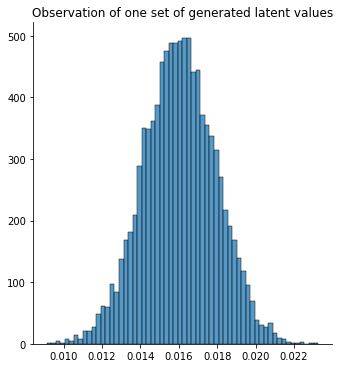

In [144]:
#We have no information telling us that these are directly related to any one latent trait
#We need a contraint in order to map values to certain traits
sns.displot(vals)
plt.title('Observation of one set of generated latent values', fontsize = 12)
plt.ylabel('')
plt.show()